### IMPORTANT!
Albumentations automatically installs `opencv-python-headless`. To make both augmentations and SelectiveSearch work, you need to uninstall every `opencv` version and install `opencv-contrib-python-headless`.
https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc

In [9]:
# speed-up using multithreads!
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

In [1]:
# !pip uninstall opencv-python opencv-python-headless

In [2]:
# !pip install opencv-contrib-python-headless

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset

In [5]:
img_size = 256 # 1024 # AM: changed because it takes too long for SelectiveSearch to run

train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                           )
)

In [6]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

In [7]:
def selective_search(img):
    """
    Takes image as an input (np.array not Tensor!)
    Returns np.array (number of bboxes x 4)
    Bboxes in format x, y, w, h (see demo notebook for example)
    """
    # create selective search segmentation object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img) 
    # Choose between fast or accurate selective Search method: fast but low recall V.S. high recall but slow 
    ss.switchToSelectiveSearchFast()
    # AM: Quality takes a looong time, maybe better to try with fast for now and see the results, if bad then change to quality
    # ss.switchToSelectiveSearchQuality() 
    # run selective search
    rects = ss.process()
    print('Total Number of Region Proposals: {}'.format(len(rects))) # TODO: comment out after making the whole trainset work
    return rects

In [14]:
def edge_boxes(model, img, max_boxes: int, alpha = None, beta = None):
    eb = cv2.ximgproc.createEdgeBoxes()
    
    # rgb_im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    edges = model.detectEdges(np.float32(img) / 255.0)

    orimap = model.computeOrientation(edges)
    edges = model.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_boxes)
#     edge_boxes.setAlpha(alpha)
#     edge_boxes.setBeta(beta)
    boxes, _ = edge_boxes.getBoundingBoxes(edges, orimap)
    return boxes

In [10]:
# selective search
train_proposals = []
for (img, _, _) in tqdm(trainset):
    proposals = selective_search(img.permute([1,2,0]).numpy())
    train_proposals.append(proposals)

  0%|          | 0/900 [00:00<?, ?it/s]

Total Number of Region Proposals: 587
Total Number of Region Proposals: 314
Total Number of Region Proposals: 1065
Total Number of Region Proposals: 871
Total Number of Region Proposals: 473
Total Number of Region Proposals: 1053
Total Number of Region Proposals: 240
Total Number of Region Proposals: 294
Total Number of Region Proposals: 411
Total Number of Region Proposals: 589
Total Number of Region Proposals: 747
Total Number of Region Proposals: 683
Total Number of Region Proposals: 312
Total Number of Region Proposals: 185
Total Number of Region Proposals: 343
Total Number of Region Proposals: 527
Total Number of Region Proposals: 260
Total Number of Region Proposals: 717
Total Number of Region Proposals: 145
Total Number of Region Proposals: 581
Total Number of Region Proposals: 625
Total Number of Region Proposals: 243
Total Number of Region Proposals: 1146
Total Number of Region Proposals: 788
Total Number of Region Proposals: 171
Total Number of Region Proposals: 1009
Total Nu

ValueError: Expected y_min for bbox (tensor(0.), tensor(-0.0003), tensor(0.7412), tensor(0.5907), tensor(1)) to be in the range [0.0, 1.0], got -0.0002500000118743628.

In [15]:
# edge boxes
edge_detection = cv2.ximgproc.createStructuredEdgeDetection('model.yml.gz')

train_proposals = []
for (img, _, _) in tqdm(trainset):
    proposals, scores = edge_boxes(edge_detection, img.permute([1,2,0]).numpy(), 1000)
    train_proposals.append(proposals)

  0%|          | 0/900 [00:00<?, ?it/s]

ValueError: Expected y_min for bbox (tensor(0.), tensor(-0.0003), tensor(0.7412), tensor(0.5907), tensor(1)) to be in the range [0.0, 1.0], got -0.0002500000118743628.

In [8]:
len(train_proposals)

162

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


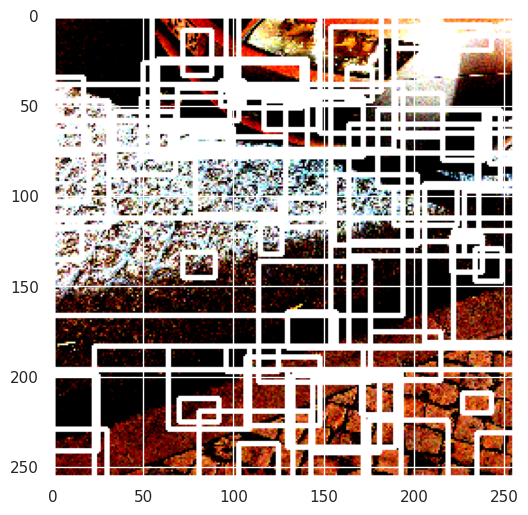

In [11]:
# (for last working img from trainset)

# number of region proposals to show
numShowRects = 70

# create a copy of original image
imOut = img.permute([1,2,0]).numpy().copy()

# itereate over all the region proposals
for i, rect in enumerate(proposals):
    # draw rectangle for region proposal till numShowRects
    if (i < numShowRects):
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)
    else:
        break

plt.imshow(imOut[...,::-1])